In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from statsmodels.stats.multitest import multipletests

DESeq2 model formula:

`~ condition + ancestry`

where `condition` is healthy melanocyte or melanoma and `ancestry` is self-reported ethnicity.

In [7]:
from pathlib import Path

wdir = Path.cwd()

In [8]:
# MC-SKCM results
hgnc_ens_map = pd.read_csv(wdir.parent / 'Data' / 'hgnc_ens_map.tsv', sep='\t')
res = pd.read_csv(wdir.parent / 'Data' / 'DESeq2_Fig4_result.csv')
res = res.merge(hgnc_ens_map, on='ens')
cols = ['hgnc'] + res.columns[res.columns != 'hgnc'].tolist()
res = res[cols]

cas = pd.read_csv(wdir.parent / 'Tables' / 'TableS4.tsv', sep='\t')
cas_dic = {'MAGE': cas.loc[cas.Class == 'MAGE', 'Conserved Antigen'], 'Conserved Antigens': cas.loc[cas.Class == 'SEGs', 'Conserved Antigen'], 'Canonical': cas.loc[cas.Class == 'Canonical', 'Conserved Antigen']}

### Helpers

In [9]:
def plot_volcano(data, pval=1e-5, p_label=None, lfc=1, fill_p0=None, gene_list=None, ax=None, legend=True):
    """Generate a volcano plot (-log10 adjusted p-value vs. log2 fold change) from DESeq2 output.
    Note: runtime can be slow if many genes are being labeled.
    
    Parameters
    ----------
    data : pandas.DataFrame or str (filepath)
        Results table from DESeq2. Expects an 'hgnc' column for gene list subsetting and gene labeling, otherwise default columns suffice.
    pval : numeric, optional
        Adjusted p-value threshold for points to be highlighted in the volcano plot.
    p_label : numeric, optional
        Adjusted p-value threshold for points to be labeled with gene names. Does not label by default.
    lfc : numeric, optional
        Absolute log fold change threshold for points to be highlighted in the volcano plot.
    fill_p0 : numeric, optional
        Value to replace 0 p-values, corresponding to the -log10 value. Necessary to take -log10 of p-values. Defaults to -log10(minimum adjusted p-value) + 5.
    gene_list : pandas.Series, Dict[str, pandas.Series], optional
        List of genes (HGNC symbols) to subset by. Will recompute Benjamini-Hochberg adjusted p-values.
        Can be passed a dictionary with subset names as keys and values as gene lists.
        Each subset will be marked with a different color.
    savename : str, optional
        Filename to save plot.
    savetype : str or List[str], optional
        File types to save plot as. Enter as string without preceding period. Defaults to png.
    
    Returns
    -------
    pandas.DataFrameL
        DataFrame of significant genes.
    """
    
    
    ## Input validation
    if gene_list is not None:
        assert isinstance(gene_list, (pd.Series, dict)), "gene_list must be a pandas.Series or dictionary of pandas.Series"
    
    
    if isinstance(data, str):
        results = pd.read_csv(data)
    else:
        results = data.copy() # Copy for data manipulation
    
    
    ## Subset DataFrame and re-adjust p-values
    if gene_list is not None:
        if isinstance(gene_list, pd.Series):
            results = results[results.hgnc.isin(gene_list)]
        elif isinstance(gene_list, dict):
            results = results[results.hgnc.isin(pd.concat(gene_list.values()))]
            def mapper(x):
                for name, ls in gene_list.items():
                    if (ls == x).any():
                        return name
            results['Group'] = results.hgnc.map(mapper)
        results = results.dropna(subset=['pvalue']) # NaN's raise an error for multipletests()
        padj = results.pvalue.copy()
        padj[padj != 0] = multipletests(padj[padj != 0], method='fdr_bh')[1] # 0's also raise an error for multipletests()
        results['padj'] = padj

            
    ## Filters
    significant = (results.padj < pval) & (results.log2FoldChange.abs() > lfc)
    on_chart = (results.padj != 0)
    off_chart = (results.padj == 0)
    if p_label is not None:
        to_label = (results.padj < p_label) & ((results.log2FoldChange > lfc) | (results.log2FoldChange < -lfc))
    
    
    ## p-values
    # Get -log10 p-values and fill 0 p-values
    results['log_padj'] = results.padj
    results.loc[results.log_padj != 0, 'log_padj'] = -np.log10(results.loc[results.log_padj != 0, 'log_padj'])
    if fill_p0 is None:
        fill_p0 = -np.log10(results.loc[on_chart, 'padj'].min()) + 5
        results.loc[results.log_padj == 0, 'log_padj'] = fill_p0
    else:
        fill_p0 = -np.log10(fill_p0)
        results.loc[results.log_padj == 0, 'log_padj'] = fill_p0

    
    ## Print some descriptive stats
    print(f'P-value threshold: {pval}\nAbsolute fold change threshold: {2**lfc}')
    if gene_list is None:
        print(f'{results[significant].shape[0]}/{results.shape[0]} ({results[significant].shape[0]/results.shape[0]*100:.2f}%) of genes meet the criteria.')
    else:
        if isinstance(gene_list, pd.Series):
            print(f'{results[significant].shape[0]}/{len(gene_list)} ({results[significant].shape[0]/len(gene_list)*100:.2f}%) of genes meet the criteria.')
        elif isinstance(gene_list, dict):
            tot_sigs = 0
            tot_gene = 0
            for name, ls in gene_list.items():
                cnt = results[significant & (results.hgnc.isin(ls))].shape[0]
                tot = len(ls)
                tot_sigs += cnt
                tot_gene += tot
                print(f'{cnt}/{tot} ({cnt/tot*100:.2f}%) of genes in the \"{name}\" gene list meet the criteria.')
            print(f'A total of {tot_sigs}/{tot_gene} ({tot_sigs/tot_gene*100:.2f}%) of genes meet the criteria.')
    
    
    ## Plotting
    if ax is None:
        fig, ax = plt.subplots()
    
    # Not significant
    sns.scatterplot(data=results[(~significant) & on_chart],
                    x='log2FoldChange', y='log_padj',
                    s=20,
                    color='gray',
                    alpha=0.5,
                    ax=ax
                   )
    sns.scatterplot(data=results[(~significant) & off_chart],
                    x='log2FoldChange', y='log_padj',
                    s=40,
                    color='gray',
                    marker='^',
                    ax=ax
                   )
    
    # Significant
    if gene_list is None or isinstance(gene_list, pd.Series):
        sns.scatterplot(data=results[significant & on_chart],
                        x='log2FoldChange', y='log_padj',
                        s=60,
                        color='blue',
                        ax=ax
                       )
        sns.scatterplot(data=results[significant & off_chart],
                        x='log2FoldChange', y='log_padj',
                        s=100,
                        color='blue',
                        marker='^',
                        ax=ax
                       )
    else:
        sns.scatterplot(data=results[significant & on_chart],
                        x='log2FoldChange', y='log_padj',
                        s=60,
                        hue='Group',
                        hue_order=gene_list.keys(),
                        ax=ax,
                        legend=(False if (significant & off_chart).any() else 'auto')
                       )
        sns.scatterplot(data=results[significant & off_chart],
                        x='log2FoldChange', y='log_padj',
                        s=100,
                        hue='Group',
                        hue_order=gene_list.keys(),
                        marker='^',
                        ax=ax
                       )
    
    # Plot thresholds
    ax.axhline(-np.log10(pval), c='k', ls='--', lw=0.5)
    ax.axvline(-lfc, c='k', ls='--', lw=0.5)
    ax.axvline(lfc, c='k', ls='--', lw=0.5)
    
    # Label data points
    if p_label is not None:
        txts = []
        for idx, x in results[to_label & on_chart].iterrows():
            txts.append(plt.annotate(x.hgnc, (x['log2FoldChange'], -np.log10(x['padj']))))
        for idx, x in results[to_label & off_chart].iterrows():
            txts.append(plt.annotate(x.hgnc, (x['log2FoldChange'], fill_p0)))
        adjust_text(txts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))
    
    # Plot formatting
    ax.set(ylabel=r'$-\log_{10}$ Adjusted p-value',
           xlabel=r'$\log_2$ Fold Change',
          )
    ax.set(ylim=[0, fill_p0 + 3])
    if legend and isinstance(gene_list, dict) and significant.any():
        ax.legend(loc='upper left')
    
    ## Return table of significant genes
    return ax, results[significant]

### Fig. 4A

P-value threshold: 0.05
Absolute fold change threshold: 2
2/32 (6.25%) of genes in the "MAGE" gene list meet the criteria.
3/48 (6.25%) of genes in the "Conserved Antigens" gene list meet the criteria.
5/7 (71.43%) of genes in the "Canonical" gene list meet the criteria.
A total of 10/87 (11.49%) of genes meet the criteria.


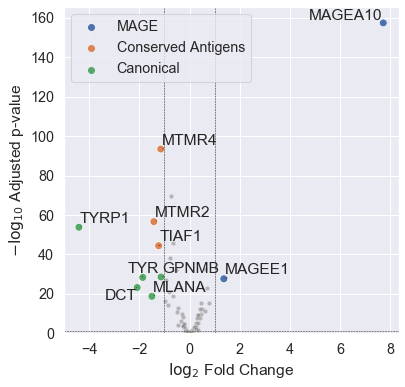

In [17]:
sns.set_theme(font='Arial Unicode MS', font_scale=1.3)
fig, ax = plt.subplots(figsize=(6, 6))
ax, segs_degs = plot_volcano(
    res,
    pval=0.05,
    p_label=0.05,
    gene_list=cas_dic,
    ax=ax
)